In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import numpy as np
import matplotlib.pyplot as plt
import csv

/home/bylehn/micromamba/envs/ifnl4-analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bylehn/micromamba/envs/ifnl4-analysis/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


### Load trajectories

In [15]:

ifnl3 = mda.Universe('ifnl3.pdb', ['ifnl3_rep1_300ns.xtc', 'ifnl3_rep2_300ns.xtc', 'ifnl3_rep3_300ns.xtc'])


In [ ]:
ifnl4 = mda.Universe('ifnl4_a3.pdb', ['ifnl4_a3_rep1_300ns.xtc', 'ifnl4_a3_rep2_300ns.xtc', 'ifnl4_a3_rep3_300ns.xtc'])

### Dynamic cross-correlation

In [10]:
def calculate_dcc(universe, selection1, selection2, start=None, stop=None, step=None):
    # Select atom groups
    group1 = universe.select_atoms(selection1)
    group2 = universe.select_atoms(selection2)
    
    # Align the trajectory to the reference frame (first frame)
    aligner = align.AlignTraj(universe, universe, select='protein and name CA',
                              in_memory=True)
    aligner.run()
    
    # Initialize arrays to store positions
    positions1 = []
    positions2 = []
    
    # Iterate through the trajectory
    for ts in universe.trajectory[start:stop:step]:
        positions1.append(group1.positions)
        positions2.append(group2.positions)
    
    # Convert to numpy arrays
    positions1 = np.array(positions1)
    positions2 = np.array(positions2)
    
    # Calculate average positions
    avg_pos1 = np.mean(positions1, axis=0)
    avg_pos2 = np.mean(positions2, axis=0)
    
    # Calculate fluctuations
    fluct1 = positions1 - avg_pos1
    fluct2 = positions2 - avg_pos2
    
    # Calculate DCC matrix
    num_atoms1 = len(group1)
    num_atoms2 = len(group2)
    dcc_matrix = np.zeros((num_atoms1, num_atoms2))
    
    for i in range(num_atoms1):
        for j in range(num_atoms2):
            numerator = np.mean(fluct1[:, i] * fluct2[:, j])
            denominator = np.sqrt(np.mean(fluct1[:, i]**2) * np.mean(fluct2[:, j]**2))
            dcc_matrix[i, j] = numerator / denominator
    
    return dcc_matrix

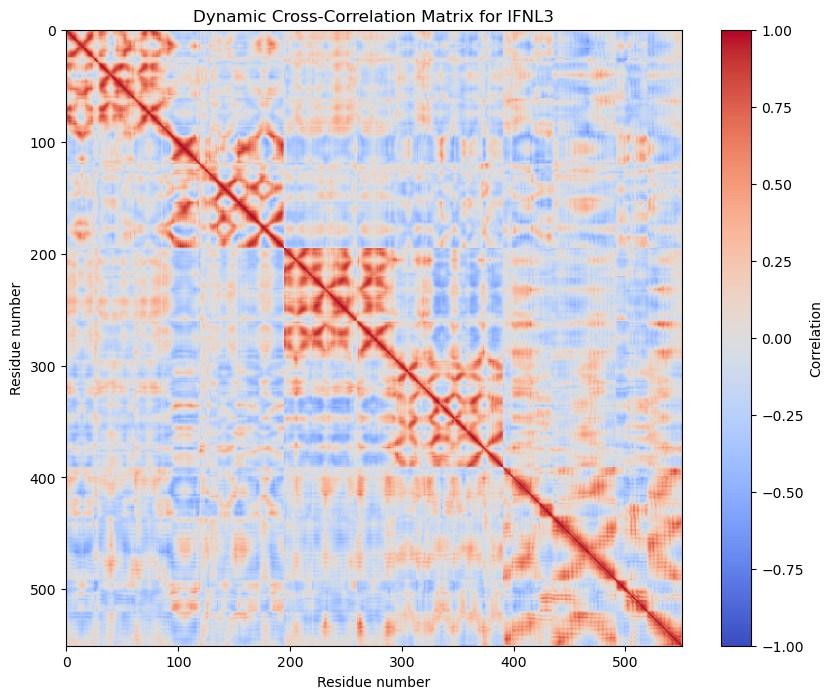

In [17]:
# Calculate DCC
dcc_ifnl3 = calculate_dcc(ifnl3, "name CA", "name CA", step=3000)

# Plot the results
plt.figure(figsize=(10, 8))
plt.imshow(dcc_ifnl3, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Dynamic Cross-Correlation Matrix for IFNL3')
plt.xlabel('Residue number')
plt.ylabel('Residue number')
plt.show()

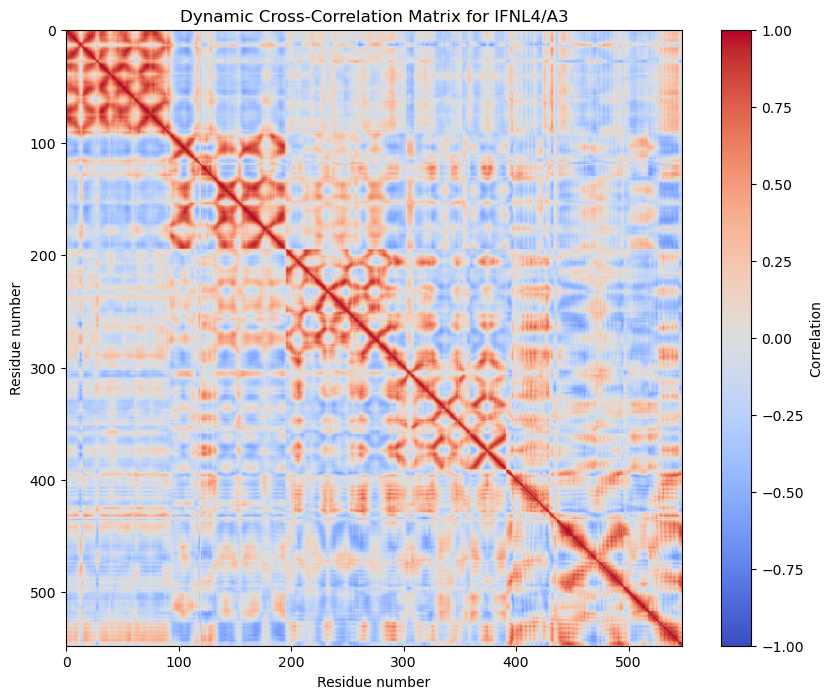

In [20]:
# Calculate DCC
dcc_ifnl4 = calculate_dcc(ifnl4, "name CA", "name CA", step=3000)

# Plot the results
plt.figure(figsize=(10, 8))
plt.imshow(dcc_ifnl4, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Dynamic Cross-Correlation Matrix for IFNL4/A3')
plt.xlabel('Residue number')
plt.ylabel('Residue number')
plt.show()